In [113]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.auto import tqdm
import seaborn as sns
plt.style.use('ggplot')
import datetime

# Задание №1

In [64]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-kuzmin/shared/problem1-reg_data.csv', sep=';')

In [65]:
reg_data.head(2)

,reg_ts,uid
0,911382223,1
1,932683089,2


In [66]:
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-kuzmin/shared/problem1-auth_data.csv', sep=';')

In [67]:
auth_data.head(2)

,auth_ts,uid
0,911382223,1
1,932683089,2


Переводим формат даты из UnixTime в классический 

In [68]:
def unix_to_time_reg_data(reg_ts):
    return datetime.datetime.fromtimestamp(reg_ts)
reg_data['reg_ts'] = reg_data['reg_ts'].apply(unix_to_time_reg_data)

In [69]:
reg_data.head(2)

,reg_ts,uid
0,1998-11-18 12:43:43,1
1,1999-07-23 02:38:09,2


In [70]:
def unix_to_time_auth_data(auth_ts):
    return datetime.datetime.fromtimestamp(auth_ts)
auth_data['auth_ts'] = auth_data['auth_ts'].apply(unix_to_time_auth_data)

In [71]:
auth_data.head(2)

,auth_ts,uid
0,1998-11-18 12:43:43,1
1,1999-07-23 02:38:09,2


Объединяем reg_data с auth_data для удобства в работе

In [72]:
data = pd.merge(reg_data, auth_data, on='uid')

In [73]:
data.head(2)

,reg_ts,uid,auth_ts
0,1998-11-18 12:43:43,1,1998-11-18 12:43:43
1,1999-07-23 02:38:09,2,1999-07-23 02:38:09


In [74]:
data.dtypes

reg_ts     datetime64[ns]
uid                 int64
auth_ts    datetime64[ns]
dtype: object

In [75]:
w_data = data

Убираем из даты время, для наших целей оно нам не нужно

In [76]:
data['reg_ts'] = data['reg_ts'].dt.date
data['auth_ts'] = data['auth_ts'].dt.date

In [77]:
data.dtypes

reg_ts     object
uid         int64
auth_ts    object
dtype: object

In [78]:
data.head(2)

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-23,2,1999-07-23


In [79]:
data['reg_ts'] = pd.to_datetime(data['reg_ts'])
data['auth_ts'] = pd.to_datetime(data['auth_ts'])

In [80]:
data.head(3)

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-23,2,1999-07-23
2,1999-07-23,2,1999-07-25


Присваиваем дату регистрации каждому UID

In [81]:
users_reg = data.groupby('uid')['reg_ts'].min().reset_index()
users_reg.head(2)

,uid,reg_ts
0,1,1998-11-18
1,2,1999-07-23


In [82]:
users_reg['uid'].nunique() == len(users_reg)  # в user_reg все uid уникальны(без дублей)

True

Приступаем к рассчетам

Enter start date (YYYY-MM-DD) or 'all' to select all data: 2017-01-01
Enter end date (YYYY-MM-DD) or 'all' to select all data: 2017-01-10
Enter UID or 'all' to select all UID: all
Enter the initial number of days for retention range(recommend entering 0 days): 0
Enter the end number of days for retention range(recommend entering 1, 7, 30 days): 15


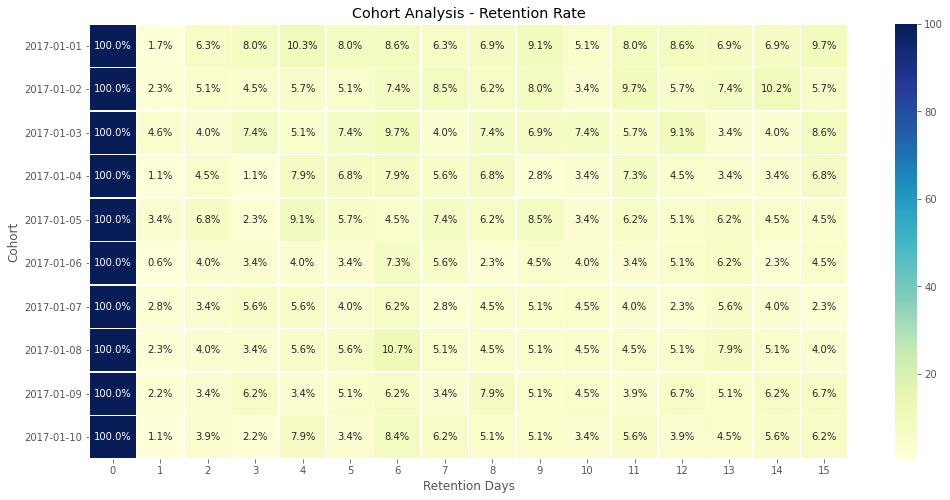

Retention:
ret_days
0     1766.000%
1       39.000%
2       80.000%
3       78.000%
4      114.000%
5       96.000%
6      136.000%
7       97.000%
8      102.000%
9      106.000%
10      77.000%
11     103.000%
12      99.000%
13     100.000%
14      92.000%
15     104.000%
Name: Retention, dtype: object
Cohort Retention:
ret_days        0     1     2     3      4     5      6     7     8     9   \
cohort                                                                       
2017-01-01  100.0%  1.7%  6.3%  8.0%  10.3%  8.0%   8.6%  6.3%  6.9%  9.1%   
2017-01-02  100.0%  2.3%  5.1%  4.5%   5.7%  5.1%   7.4%  8.5%  6.2%  8.0%   
2017-01-03  100.0%  4.6%  4.0%  7.4%   5.1%  7.4%   9.7%  4.0%  7.4%  6.9%   
2017-01-04  100.0%  1.1%  4.5%  1.1%   7.9%  6.8%   7.9%  5.6%  6.8%  2.8%   
2017-01-05  100.0%  3.4%  6.8%  2.3%   9.1%  5.7%   4.5%  7.4%  6.2%  8.5%   
2017-01-06  100.0%  0.6%  4.0%  3.4%   4.0%  3.4%   7.3%  5.6%  2.3%  4.5%   
2017-01-07  100.0%  2.8%  3.4%  5.6%   5.6%  4.0%  

In [83]:
# Функция рассчитывает Retention по пользователям из w_data
def retention_calc(w_data, start_date=None, stop_date=None, uid=None, range_retention=None):
    w_data = w_data.copy()  # создаем копию df для исключения ошибок
    w_data['reg_date'] = pd.to_datetime(w_data['reg_ts'])
    w_data['log_date'] = pd.to_datetime(w_data['auth_ts'])
    
# Сортировка данных по заданному пользователем диапазону в start_date и stop_date + uid
    if start_date is not None and stop_date is not None:
        w_data = w_data[(w_data['reg_date'] >= start_date) & (w_data['reg_date'] <= stop_date)]
    if uid is not None and uid != 'all':
        w_data = w_data[w_data['uid'] == int(uid)]

# Вычисляем разницу между log_date и reg_date и создаем столбец ret_days для расчета retntion period
    w_data['ret_days'] = (w_data['log_date'] - w_data['reg_date']).dt.days

# Сортировка данных по заданному пользователем диапазону в range_retention
    if range_retention is not None:
        w_data = w_data[
            (w_data['ret_days'] >= range_retention[0])
            & (w_data['ret_days'] <= range_retention[1])]

    retention = w_data.groupby('ret_days')['uid'].nunique()

    return retention, w_data

# Функция считает retention rate пользователей по каждой когорте
def cohort_analysis(w_data):
    w_data['cohort'] = w_data['reg_date'].dt.to_period('D')
    cohort_counts = w_data.groupby(['cohort', 'ret_days'])['uid'].nunique()
    cohort_sizes = w_data.groupby('cohort')['uid'].nunique()
    retention_rate = cohort_counts / cohort_sizes

    return retention_rate, w_data

# Переменные для ввода пользователем данных для сортировки (период отбора данных, uid, 
# диапозон просмотра retention)
start_date = input("Enter start date (YYYY-MM-DD) or 'all' to select all data: ")
stop_date = input("Enter end date (YYYY-MM-DD) or 'all' to select all data: ")
uid = input("Enter UID or 'all' to select all UID: ")
retention_start = int(input("Enter the initial number of days for retention range(recommend entering 0 days): "))
retention_end = int(input("Enter the end number of days for retention range(recommend entering 1, 7, 30 days): "))
# классические модели 1, 7, 30 дней и 1 год
range_retention = (retention_start, retention_end)


# Обработка ввода данных пользователем (если вводится 'all' - присваиваем 'None' 
# для использования всего диапозона дат).
if start_date.lower() == 'all':
    start_date = None
elif start_date == '':
    start_date = pd.to_datetime('1998-11-17') 

if stop_date.lower() == 'all':
    stop_date = None
elif stop_date == '':
    stop_date = pd.to_datetime('2018-02-18') 


retention, retention_data = retention_calc(w_data, start_date=start_date, stop_date=stop_date,
                                           uid=uid, range_retention=range_retention)
retention_table = pd.DataFrame({'Retention': retention})
cohort_retention, cohort_data = cohort_analysis(retention_data)


# Производим сортировку cohort_data и cohort_retention_table по заданному пользователем периоду даты.
if start_date is not None and stop_date is not None:
    cohort_data = cohort_data[(cohort_data['cohort'] >= start_date) & (cohort_data['cohort'] <= stop_date)]

cohort_retention_table = cohort_retention.unstack(level='ret_days') * 100  # получаем процентное значение

if start_date is not None and stop_date is not None:
    cohort_retention_table = cohort_retention_table.loc[start_date:stop_date]

# добавим знак процента в вывод
cohort_retention_table_str = cohort_retention_table.applymap(lambda x: '{:.1f}%'.format(x))

# Визуализируем cohort_retention_table в виде heatmap
plt.figure(figsize=(17, 8))
sns.heatmap(cohort_retention_table, annot=cohort_retention_table_str, fmt="", linewidths=.5, cmap="YlGnBu")
plt.title("Cohort Analysis - Retention Rate")
plt.ylabel("Cohort")
plt.xlabel("Retention Days")
plt.show()

# Выводим таблицу retention_table и cohort_retention_table
print("Retention:")
print(retention_table['Retention'].apply(lambda x: '{:.3f}%'.format(x)))

print("Cohort Retention:")
print(cohort_retention_table_str)

In [84]:
cohort_retention_table_str

ret_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cohort,,,,,,,,,,,,,,,,
2017-01-01,100.0%,1.7%,6.3%,8.0%,10.3%,8.0%,8.6%,6.3%,6.9%,9.1%,5.1%,8.0%,8.6%,6.9%,6.9%,9.7%
2017-01-02,100.0%,2.3%,5.1%,4.5%,5.7%,5.1%,7.4%,8.5%,6.2%,8.0%,3.4%,9.7%,5.7%,7.4%,10.2%,5.7%
2017-01-03,100.0%,4.6%,4.0%,7.4%,5.1%,7.4%,9.7%,4.0%,7.4%,6.9%,7.4%,5.7%,9.1%,3.4%,4.0%,8.6%
2017-01-04,100.0%,1.1%,4.5%,1.1%,7.9%,6.8%,7.9%,5.6%,6.8%,2.8%,3.4%,7.3%,4.5%,3.4%,3.4%,6.8%
2017-01-05,100.0%,3.4%,6.8%,2.3%,9.1%,5.7%,4.5%,7.4%,6.2%,8.5%,3.4%,6.2%,5.1%,6.2%,4.5%,4.5%
2017-01-06,100.0%,0.6%,4.0%,3.4%,4.0%,3.4%,7.3%,5.6%,2.3%,4.5%,4.0%,3.4%,5.1%,6.2%,2.3%,4.5%
2017-01-07,100.0%,2.8%,3.4%,5.6%,5.6%,4.0%,6.2%,2.8%,4.5%,5.1%,4.5%,4.0%,2.3%,5.6%,4.0%,2.3%
2017-01-08,100.0%,2.3%,4.0%,3.4%,5.6%,5.6%,10.7%,5.1%,4.5%,5.1%,4.5%,4.5%,5.1%,7.9%,5.1%,4.0%
2017-01-09,100.0%,2.2%,3.4%,6.2%,3.4%,5.1%,6.2%,3.4%,7.9%,5.1%,4.5%,3.9%,6.7%,5.1%,6.2%,6.7%


In [85]:
cohort_retention_table.to_excel('cohort_retention_table.xlsx', index=False)

##### Для удобства считывания данных прикладываю ссылку на визуализацию в Tableau
##### https://public.tableau.com/app/profile/maksim.kuzmin/viz/Final_project_v1_Retention/Sheet2?publish=yes

# Задание №2

Исходные данные:
1. ARPU в тестовой группе(b_group) выше на 5%, чем в контрольной(a_group);
2. В контрольной группе(a_group) 1928 игроков из 202103 платящие (~0.95%);
3. В тестовой(b_group) группе 1805 из 202667 платящие (~0.89%).

Объявим гипотезы:

H0 – никакого различия между группами a & b нет

H1 – группы a & b значимо различаются

In [86]:
ab_group = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-kuzmin/p1_t2', sep=';')

##### Проверим полученные данные

In [87]:
ab_group.head(2)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a


In [88]:
ab_group.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [89]:
ab_group.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [90]:
ab_group.groupby('testgroup').agg({'revenue': 'sum'}).round(2).reset_index()

,testgroup,revenue
0,a,5136189
1,b,5421603


In [91]:
ab_group.groupby('testgroup').agg({'revenue': 'mean'}).round(2).reset_index()

,testgroup,revenue
0,a,25.41
1,b,26.75


In [92]:
ab_group.groupby('testgroup').agg({'revenue': 'median'}).round(2).reset_index()

,testgroup,revenue
0,a,0.0
1,b,0.0


#### Разделим на две группы (а & b) для удобства в работе

In [93]:
a_group = ab_group[ab_group['testgroup'] == 'a']
a_group = a_group.copy()
a_group.drop('testgroup', axis=1, inplace=True)
a_group.shape

(202103, 2)

In [94]:
b_group = ab_group[ab_group['testgroup'] == 'b']
b_group = b_group.copy()
b_group.drop('testgroup', axis=1, inplace=True)
b_group.shape

(202667, 2)

#### Проверим предоставленную информацию об ARPU для надежности

Для a_group

In [95]:
revenue_sum_a = a_group['revenue'].sum()  # суммируем доход по группе А
total_users_a = a_group['user_id'].nunique()  # считаем уникальное кол-во пользователей
APRU_a = revenue_sum_a / total_users_a  # считаем показатель ARPU
APRU_a.round(2)

25.41

Для b_group

In [96]:
revenue_sum_b = b_group['revenue'].sum()  # суммируем доход по группе b
total_users_b = b_group['user_id'].nunique()  # считаем уникальное кол-во пользователей
APRU_b = revenue_sum_b / total_users_b  # считаем показатель ARPU
APRU_b.round(2)

26.75

Вывод по ARPU

In [97]:
diff_a_b = ((APRU_b - APRU_a) / APRU_a) * 100
diff_a_b.round(2)

5.26

Наше вычисление подтвердило разницу ARPU между группами в 5% (точнее в 5.26%)

#### Проверим данные по группам на аномалии посредством визуального анализа
#### и тестов на нормальность распределения

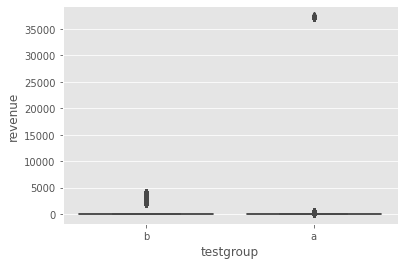

In [98]:
sns.boxplot(x='testgroup', y='revenue', data=ab_group)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


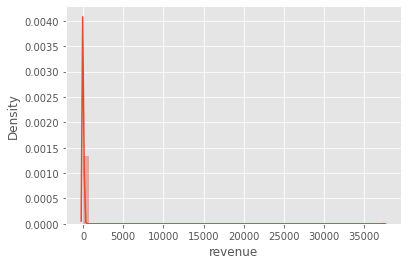

In [99]:
sns.distplot(a_group.revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


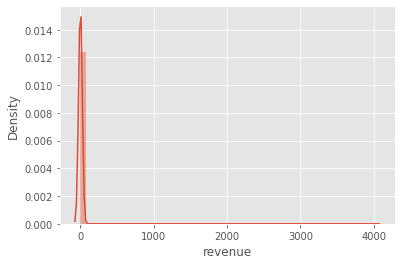

In [100]:
sns.distplot(b_group.revenue)

После построения графиков отчетливо видно, что распределения не нормальны и есть сильные выбросы в a_group. Это говорит нам о том, что использование таких методов как ANOVA, линейная регрессия, корреляция Пирсона могут дать недостоверные и/или искаженные результаты.

Дополнительно проведем тест на нормальность данных: Андерсона-Дарлинга.
Так как тест Шапиро-Вилка предполагает использование небольшого кол-ва данных и менее точно отражает результаты при наличии выбросов, проведем тест Андерсона-Дарлинга, который более точно работает с выбросами и с имеющимся у нас кол-вом данных.

In [101]:
result_anderson_a = stats.anderson(a_group['revenue'])
result_anderson_b = stats.anderson(b_group['revenue'])
print(f'Результат теста Андерсона-Дарлинга для a_group: {result_anderson_a}')
print(f'Результат теста Андерсона-Дарлинга для b_group: {result_anderson_b}')

Результат теста Андерсона-Дарлинга для a_group: AndersonResult(statistic=77221.00043053087, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Результат теста Андерсона-Дарлинга для b_group: AndersonResult(statistic=77383.39298710425, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


На основании графиков и полученных результатов теста Андерсона-Дарлинга можем сказать, что присутствуют значительные выбросы в group_a и распределения не являются нормальными.

#### Посмотрим кол-во нулевых значений в столбце revenue по группам

In [102]:
count_zeros_a = (~a_group['revenue'].astype(bool)).sum(axis=0)
count_zeros_b = (~b_group['revenue'].astype(bool)).sum(axis=0)
print(f'Количество нулевых строк в revenue (a_group) = {count_zeros_a}')
print(f'Количество строк с ненулевым значением в revenue (a_group) = {a_group.shape[0] - count_zeros_a}')
print(f'Количество нулевых строк в revenue (b_group) = {count_zeros_b}')
print(f'Количество строк с ненулевым значением в revenue (b_group) = {b_group.shape[0] - count_zeros_b}')

Количество нулевых строк в revenue (a_group) = 200175
Количество строк с ненулевым значением в revenue (a_group) = 1928
Количество нулевых строк в revenue (b_group) = 200862
Количество строк с ненулевым значением в revenue (b_group) = 1805


Мы видим, что ~ 99% данных занимают 'нулевые' revenue, что при проведении тестов на нормальность будет значительно искажать результаты.

#### Попробуем убрать из групп все 'нулевые' значения и протестируем

Но перед этим посмотрим на кол-во выбросов в данных и их сумму в revenue group_a

In [103]:
a_group[a_group.revenue != 0]

,user_id,revenue
72,73,351
341,342,290
385,386,250
416,417,37324
712,713,255
...,...,...
404304,404305,360
404315,404316,262
404543,404544,369
404602,404603,251


In [104]:
a_group_nonull_outliers = a_group.query("revenue != 0 & revenue >= 5000")
res_outliers_a = len(a_group_nonull_outliers) / len(a_group[a_group.revenue != 0]) * 100
round_result_a = '{:.2f}'.format(res_outliers_a)
print(f'Кол-во строк в выбросах a_group: {len(a_group_nonull_outliers.revenue)} строки')
print(f'Выбросы составляют {round_result_a}% ({len(a_group_nonull_outliers.revenue)} строки) '
      f'от всей a_group без нулевых значений ({len(a_group[a_group.revenue != 0])} строки)')
print(f'Сумма выбросов a_group: {a_group_nonull_outliers.revenue.sum()}')
print(f'Сумма выбросов в revenue в a_group составляет '
      f'{(a_group_nonull_outliers.revenue.sum() / a_group.revenue.sum() *100).round(1)}% '
      f'от общей суммы revenue в group_a {a_group.revenue.sum()}')

Кол-во строк в выбросах a_group: 123 строки
Выбросы составляют 6.38% (123 строки) от всей a_group без нулевых значений (1928 строки)
Сумма выбросов a_group: 4590252
Сумма выбросов в revenue в a_group составляет 89.4% от общей суммы revenue в group_a 5136189


Как мы видим, сумма выбросов revenue a_group составляет большую часть(89.4%) от общей суммы revenue a_group, что говорит нам о том, что данные в a_group сильно несбалансированы, и, конечно, не распределны нормально. Также можем предположить, что так называемые "выбросы" могут являться не выбросами, а результатом набора предложений a_group.  Поэтому проведем тесты  без 'нулевых' значений оставив выбросы, как значимаю часть a_group. Учитывая специфику наших данных будем использовать Бутстрап и медиану (более усточйчива к выбросам).

#### Бутстрап проверка (без 'нулевых' значений)

In [105]:
a_group_not_null = a_group[a_group.revenue != 0]
a_group_test = a_group_not_null.revenue
b_group_not_null = b_group[b_group.revenue != 0]
b_group_test = b_group_not_null.revenue

In [106]:
def get_bootstrap(
    a_group_test,  # числовые значения первой выборки
    b_group_test,  # числовые значения второй выборки
    boot_it=2000,  # количество бутстрэп-подвыборок
    statistic=np.median,  # интересующая нас статистика (median)
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = a_group_test.sample(
            len(a_group_test), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = b_group_test.sample(
            len(b_group_test), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

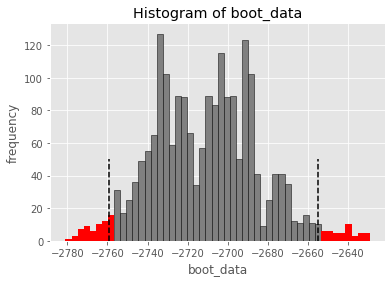

{'quants':                0
 0.025 -2759.0125
 0.975 -2654.9750,
 'p_value': 0.0}

In [107]:
get_bootstrap(a_group_test, b_group_test)

Бутстрап показывает нам, что между a_group и b_group имеются значимые различия, а значит отвергнуть гипотезу H1(о различии двух групп) на данный момент мы не можем.

In [108]:
a_group_without_null_outliers = a_group_not_null[a_group_not_null.revenue <= 5000]
a_group_test_2 = a_group_without_null_outliers.revenue

b_group_without_null = b_group[b_group.revenue != 0]
b_group_test_2 = b_group_without_null.revenue

ab_group_nonull = ab_group.query("revenue != 0")

In [109]:
len(a_group_without_null_outliers) == len(b_group_without_null)

True

Интересное наблюдение, после удаления значений > 5000 и 'нулевых' значений из a_group и 'нулевых' значений из b_group (выбросов в b_group нет), длины обоих df совпали (1805 строк).

#### Построим графики для новых выборок (без 'нулевых' значений)

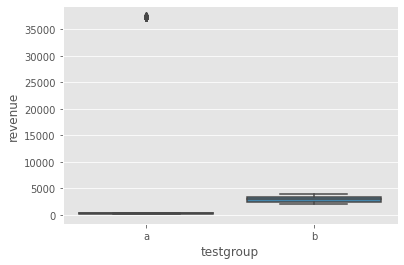

In [110]:
sns.boxplot(x='testgroup', y='revenue', data=ab_group_nonull)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


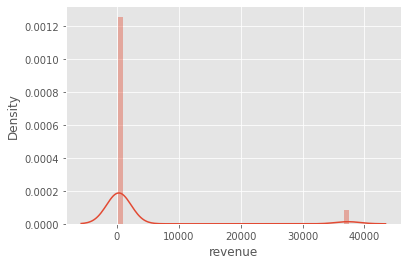

In [111]:
sns.distplot(a_group_not_null.revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


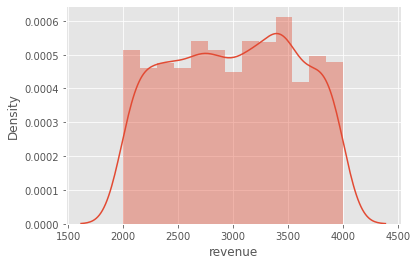

In [112]:
sns.distplot(b_group_without_null.revenue)

Исключение 'нулевых' значений дало нам не особо более читабельные графики, на которых все так же видно ненормальное распределение и несбалансированность данных между группами, очень большая разница в цифрах в revenue, если точнее, то в ~10 раз.

## Вывод

Принимая во внимание проведенный тест бутстрап, очистку данных(удаление 'нулевых значений') и анализ графиков, считаю абсолютно обоснованным отклонить H0 гипотезу и заключить, что b_group(тестовая группа) значимо отличается от a_group(контрольная группа) и приносит большую прибыль компании, а значит наборы акционных предложений b_group работают корректно и стоит распространить их(наборы акционных предложений b_group) на всех пользователей для увеличения прибыли компании.


P.S. в идеале отобрать новые выборки согласно методологии и еще раз провести наш анализ:
1. Выборка должна быть репрезентативной (отражать разнообразие ГС)
2. Размер выборки должен быть достаточным для обнаружения различий
3. Выборка должна быть случайной
4. Постараться исключить из выборки выбросы
5. Учесть специфические факторы, влияющие на выборки.

#### Задание №3

1. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. 
В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. 
  С помощью каких метрик можно оценить результаты последнего прошедшего события?



2. Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Выводы

1.Так как тематические события проводятся ограниченное кол-во времени в месяц, то они должны вызывать повышенный интерес у игроков, т.к. это даёт возможность получить дополнительные и уникальные предметы/бонусы/монеты для персонажа или сада, что в свою очередь улучшит их игровые показатели, даст  преимущество перед другими игроками(по меньшей мере моральное удовольствие), которые не участвуют в тематических событиях и не получают уникальные предметы/бонусы/монеты, а значит их сад и персонажи развиваются чуть медленнее. Также устанавливается условие по времени прохождения уровней, что усложняет задачу игрокам, а значит надо принимать участие в тематическом событии как можно раньше после его старта. Принимая во внимание вышеизложенное, считаю желательным набором для оценки результатов следующие метрики:


ОХВАТ(общее кол-во игроков) - оценить до начала тематического события и вовремя его проведения, путем подсчета уникальных ID игроков участвующих в событии, это позволит оценить заинтересованность и качество самого события;

ДЛИТЕЛЬНОСТЬ СЕАНСА - измерить продолжительность игровой сессии игроков в обычное время (без событий) и во время их проведения, также можно подсчитать кол-во входов в игру. Если события увлекательны и интересны игрокам, то время, проведенное в игре и кол-во входов будет больше.

RETENTION RATE(коэффициент удержания) - измерить процент пользователей, которые возвращаются в игру после их первого входа. Если процент удержания падает, то подумать над введением дополнительных наград игрокам в случае участия в каждом событии или выполнения минимального задания.

CHURN RATE(коэффициент оттока) - отследить изменения процента игроков, которые перестали пользоваться игрой. Вряд ли данные события могут отрицательно повлиять на эту метрику, но в случае однотипности событий или снижения мотивации игроков, эта метрика покажет отток, и в этом случае необходимо пересмотреть формат событий.

ПРОГРЕСС ПРОХОЖДЕНИЯ - важно измерить средний процент прохождения каждого уровня игроками (например, всего 5 уровней, где 1 уровень это - легко, а 5 - очень сложно, условно 1 уровень проходит 90% игроков, 2 уровень 75% игроков, ... 5 уровень 20% игроков), это позволит отслеживать корректность сложности составления уровней и на сколько интересно\сложно они составлены для игроков, а также кол-во игроков прошедших каждый из этапов из месяца в месяц.

КОЛ-ВО ОБРАЩЕНИЙ В ПОДДЕРЖКУ / ОТЗЫВЫ - позволит оценить качество проработки событий и работы поддержки. Можно высчитать среднее кол-во обращений по каждому событию (позитивное / негативное), например за три месяца проведения событий и использовать как ориентир. В случае превышения среднего значения по негативным отзывам/обращениям скорректировать последующие события с учетом полученных замечаний.

РЕГИСТРАЦИЯ НОВЫХ ПОЛЬЗОВАТЕЛЕЙ - сравнить с обычным периодом (без событий) среднее кол-во новых игроков и во время начала события. Позволит выяснить увеличивают ли события приток новых игроков.

МОНЕТИЗАЦИЯ - в случае наличия в игре возможности приобретать доп. бонусы/преимущества, надо сравнить средний чек в период без событий и вовремя. Это позволит узнать тратят ли игроки больше денег на игровой процесс во время событий. Также можем рассчитать такие метрики как ARPU(средний доход на одного пользователя), ARPPU(средний доход на одного платящего пользователя).


2.В данном случае более важнными метриками могут стать:

CHURN RATE - важно следить за оттоком игроков, так как усложнение игрового процесса в качестве отката, может снизить заинтересованность игроков.

RETENTION RATE(коэффициент удержания) - также будет являться важной метрикой, так как создавая откат в уровнях, игроки могут начать терять интерес и перестанут участвовать в событиях.

ПРОГРЕСС ПРОХОЖДЕНИЯ - данная метрика однозначно будет отличаться от версии без откатов, так как психологически некоторые игроки будут "нервничать" во время откатов (особенно на последних уровнях) и переставть участвовать в событиях. Надо внимательно следить за этой метрикой и в случае сильного снижения прохождения определенных уровней корректировать их сложность или повышать ценность наград за их прохождение, что бы сохранить интерес и мотивацию игроков.

Также будет полезно отслеживать отзывы/обращения в поддержку, будет представление о реакции игроков и может указать на технические сложности в прохождении или процессе откатов.
